In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fast')

Se carga el dataset

In [5]:
df = pd.read_excel('./diabetes_prediction_dataset.xlsx')

Se remueven las filas nulas del dataset así como se aplica label encoding para los campos que son clasificaciones.

In [6]:
encoded_df = df.dropna()
encoded_df['gender'] = LabelEncoder().fit_transform(df['gender']).astype(np.float64)
encoded_df['smoking_history'] = LabelEncoder().fit_transform(df['smoking_history']).astype(np.float64)

Se genera la tabla de correlación para buscar las variables que tengan una mayor influencia con la diabetes.

In [7]:
encoded_df.corr()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.000000,-0.030656,0.014203,0.077696,-0.077919,-0.022994,0.019957,0.017199,0.037411
age,-0.030656,1.000000,0.251171,0.233354,0.228608,0.337396,0.101354,0.110672,0.258008
hypertension,0.014203,0.251171,1.000000,0.121262,0.093177,0.147666,0.080939,0.084429,0.197823
heart_disease,0.077696,0.233354,0.121262,1.000000,0.027598,0.061198,0.067589,0.070066,0.171727
smoking_history,-0.077919,0.228608,0.093177,0.027598,1.000000,0.179361,0.037369,0.040219,0.094290
bmi,-0.022994,0.337396,0.147666,0.061198,0.179361,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.019957,0.101354,0.080939,0.067589,0.037369,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.017199,0.110672,0.084429,0.070066,0.040219,0.091261,0.166733,1.000000,0.419558
diabetes,0.037411,0.258008,0.197823,0.171727,0.094290,0.214357,0.400660,0.419558,1.000000


Se definen la funciones para poder dividir el conjunto de datos en subconjunto de entrenamiento y prueba.

In [8]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

def split_shuffle (partitions: tuple[int, ...], X = np.array, Y = np.array):
  X, Y = X.copy(), Y.copy()
  np.random.shuffle(X)
  np.random.shuffle(Y)
  return split_sequencial(partitions, X, Y)

Se obtiene todas las variables independientes y se apilan en una sola matriz. A esta última la estandarizamos.

In [9]:
X1 = encoded_df['gender'].values
X2 = encoded_df['age'].values
X3 = encoded_df['hypertension'].values
X4 = encoded_df['heart_disease'].values
X5 = encoded_df['smoking_history'].values
X6 = encoded_df['bmi'].values
X7 = encoded_df['HbA1c_level'].values
X8 = encoded_df['blood_glucose_level'].values
Y = encoded_df['diabetes'].values
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8))
X = StandardScaler().fit_transform(X)
X.shape

(100000, 8)

Se divide en los subcojuntos de entrenamiento y prueba el conjunto de datos original.

In [10]:
X_train, Y_train, X_test, Y_test = split_shuffle((80, 20), X, Y)
(X_train.shape, X_test.shape)

((80000, 8), (20000, 8))

Se muestra la distribución de los valores que no tienen diabetes y los que sí. Rojo y azul respectivamente.

{0: 91500, 1: 8500}


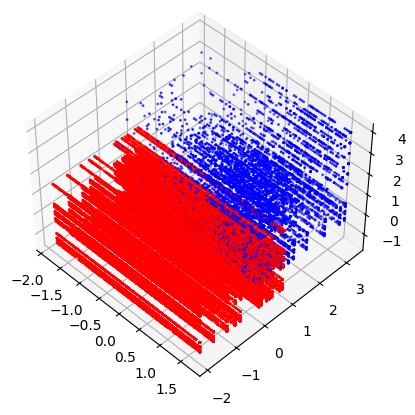

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colores=['red','blue']
asignar=[]
values = {0: 0, 1: 0}
for row in Y:
    values[row] = values[row] + 1
    asignar.append(colores[row])
print(values)
ax.scatter(X[:, 1], X[:, 6], X[:, 7], c=asignar, s=1)
ax.view_init(elev=45, azim=-45)
plt.show()

Implementación de K Means y predicciones.

In [12]:
%%time
def init_centroids(X, k):
    # Selecciona k puntos aleatorios como centroides iniciales
    indexes = np.random.choice(len(X), k, replace=False)
    return X[indexes]

def update_centroids(X, classifiers, k):
    # Calcula nuevos centroides basados en los puntos asignados a cada cluster
    #nuevos_centroides = np.vectorize(lambda i: X[asignaciones == i].mean(axis=0))(list(range(k)))
    return np.array([X[classifiers == i].mean(axis=0) for i in range(k)])

class K_means:
    def __init__ (self, K, iters=100, tol=0.001):
        self.K = K
        self.iters = iters
        self.tol = tol
        self.centroids = None
        self.classifiers = None

    def fit (self, X):
        self.centroids = init_centroids(X, self.K)
        for _ in range(self.iters):
            self.classifiers = self.predict(X)
            old_centroid = self.centroids
            self.centroids = update_centroids(X, self.classifiers, self.K)
            if np.linalg.norm(self.centroids - old_centroid) < self.tol:
                break

    def predict (self, X):
        # Asigna cada nuevo punto al cluster más cercano
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

models = [K_means(2, 1000, 0.0001) for i in range(50)]
for model in models:
    model.fit(X_train)

model = max(models, key = lambda model: accuracy_score(Y_test, model.predict(X_test)))

print(f'Train score: {accuracy_score(Y_train, model.classifiers)}')
print(f'Test score: {accuracy_score(Y_test, model.predict(X_test))}')

Train score: 0.8810875
Test score: 0.88565
CPU times: user 10.6 s, sys: 2.16 s, total: 12.8 s
Wall time: 12.8 s


Se gráfican los valores de las predicciones y los centroides

{0: 19204, 1: 796}


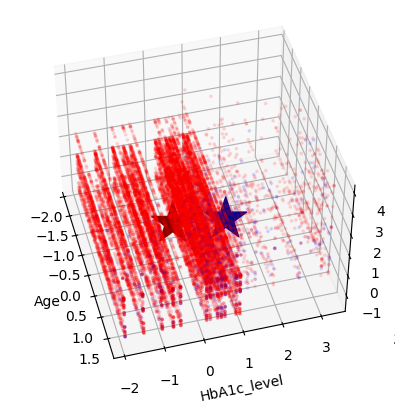

In [40]:
## colors=['red','blue']
classifiers_colors=[]
C = model.centroids
classifiers = model.predict(X_test)
values = {0: 0, 1: 0}
for row in classifiers:
    values[row] = values[row] + 1
    classifiers_colors.append(colors[row])

print(values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 1], X_test[:, 6], X_test[:, 7], c=classifiers_colors, s=3, alpha=0.1)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=['#8c0000', '#000689'], s=1000, alpha=1)
ax.view_init(elev=45, azim=-15)
ax.set_xlabel('Age')
ax.set_ylabel('HbA1c_level')
ax.set_zlabel('blood_glucose_level')
plt.savefig('k-means.png')